<a href="https://colab.research.google.com/github/desaiankitb/pytorch-basics/blob/main/beginner/00_nn_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# What is `torch.nn` really?
PyTorch provides the elegantly designed modules and classes [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`Dataset`](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset), and [`DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) to help you create and train neural networks. In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they are doing. To develop this understanding, we first train basic neural net on the MNIST data set without using any features from these models; we will initially only use the most basic PyTorch tensor functionality. Then, we will incrementally add one feature from `torch.nn`, `torch.optim`, `Dataset`, or `DataLoader` at a time, showing exactly what each piece does, and how it works to make the code either more concise, or more flexible. 

## MNIST datasetup 
We will use the classic [`MNIST`](http://deeplearning.net/data/mnist/) dataset, which consists of black-and-white images of hand-drawn digits (between 0 and 9). 

We will use [`pathlib`](https://docs.python.org/3/library/pathlib.html) for dealing with paths (part of the Python 3 standard lib), and will download the dataset using [`requests`](http://docs.python-requests.org/en/master/). We will only import modules when we use them, so you can see exactly what is being used at each point. 

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
  content = requests.get(URL + FILENAME).content
  (PATH / FILENAME).open("wb").write(content)

This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data. 

In [3]:
import pickle
import gzip


with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let us take a look at one; we need to reshape it to 2D first. 

(50000, 784)


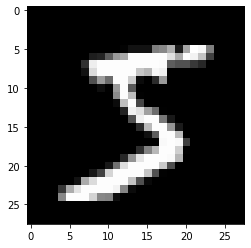

In [4]:
from matplotlib import pyplot
import numpy as np 

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch uses `torch.tensor`, rather than numpy arrays, so we need to convert our data. 

In [5]:
import torch 
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural network from scratch (no `torch.nn`)

Let us first create a model using nothing but PyTorch tensor operations. We are assuming you are already familiar with the basics of neural networks. (If you are not, you can learn them at [`course.fast.ai`](https://course.fast.ai)

PyTorch provides mothods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTorch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation *automatically*! 

For the weights, we set `requires_grad` **after** the initialization, since we don't want that step included in the gradient. (Note that a trailing `_` in PyTorch signifies that the operations is performed in-place.) 

> **Note:** we are initializing the weights here with [`Xavier initialisation` ](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) by multiplying with $\frac{1}{\sqrt(n)}$



In [6]:
import math 

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch's ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! So let us just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we will write *log_softmax* and use it. Remember: although PyTorch provides a lot of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically. 

In [7]:
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
  return log_softmax(xb @ weights + bias)

In the above, the `@` stands for dot product operation. We will call our function on one batch of data (in this case, 64 images). This is one *forward pass*. Note that our predictions would not be any better than random at this stage, since we start with random weights.  

In [8]:
bs = 64 # batch size 

xb = x_train[0:bs] # a mini-batch from x 
preds = model(xb) # predictions 
preds[0], preds.shape
print(preds[0], preds.shape)


tensor([-1.9127, -2.3297, -2.6777, -2.8254, -2.4541, -2.3137, -2.4055, -2.4246,
        -2.0539, -2.0010], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the `preds` tensor contains not only the tensor values, but also a gradient function. We will use this later to do backprop. 

Let us implement negative log-likelihood to use as the loss function (again, we can just use standard Python):

In [9]:
def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

loss_func = nll

let us check our loss with our random model, so we can see if we improve after a backprop pass later. 

In [10]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3227, grad_fn=<NegBackward>)


Let us also implement a function to calculate the accuracy of our model. For each prediction, if the index with the largest value matches the target value, then the prediction was correct. 

In [11]:
def accuracy(out, yb):
  preds = torch.argmax(out, dim=1)
  return (preds == yb).float().mean()

Let us check the accuracy of our random model, so we can see if our accuracy improves as our loss improves. 

In [12]:
print(accuracy(preds, yb))

tensor(0.1250)


We can now run a loop. For each iteration, we will: 
* select a mini-batch of data (of size `bs`)
* use the model to make predictions 
* calculate the loss 
* `loss.backward()` updates the gradients of the model, in this case, `weights` and `bias`. 

We now use these gradients to update the weights and bias. We do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch's Autograd records operations [here](https://pytorch.org/docs/stable/notes/autograd.html).

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. `loss.backward()` *adds* gradients to whatever it already stored, rather than replacing them). 

> **Tip:** You can use the standard python debugger to step through PyTorch code, allowing you to check the various variable values at each step. Uncomment `set_trace()` below to try it out. 

In [13]:
!pip install ipdb

     |████████████████████████████████| 786 kB 5.1 MB/s 
     |████████████████████████████████| 368 kB 49.9 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=abee1f4831f8b8d82e0ea3ec12ff8d756c7672ca7dca50d5c53df89b2c8cabbd
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 

In [14]:
# from IPython.core.debugger import set_track

lr = 0.5 # learning rate 
epochs = 2 # how many epochs to train for 

for epoch in range(epochs):
  for i in range((n-1) // bs + 1):
    # set_trace()
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr 
      weights.grad.zero_()
      bias.grad.zero_()

That is it: we have created and trained a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch! 

Let us check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have descreased and accuracy to have increased, and they have.

In [15]:
print(loss_func(model(xb), yb), accuracy(model(xb),yb))

tensor(0.0814, grad_fn=<NegBackward>) tensor(1.)


## Using `torch.nn.functional` 
We will now refactor our code, so that it does the same thing as before, only we will start taking advantage of PyTorch's `nn` classes to make it more concise and flexible. At each step from here, we should be making our code one or more of: shorter, more understandable, and/or more flexible. 

The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with those from `torch.nn.functional` (which is generally imported into the namespace `F` by convention). This module contains all the functions in the `torch.nn` library (whereas other parts of the library contain classes). As well as a wide range of loss and activation functions, you wil also find here some convenient functions for creating neural nets, such as pooling functions. (There are also functions for doing convolutions, linear layers, etc, but as we will see, these are usually better handled using other parts of the library). 

If you are using negative log likelihood loss and log softmax activation, then PyTorch provides single function `F.cross_entropy` that combines the two. So we can even remove the activation function from our model. 

In [16]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
  return xb @ weights + bias 

Note that we no longer call `log_softmax` in the `model` function. Let us confirm that our loss and accuracy are the same as before: 

In [17]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0814, grad_fn=<NllLossBackward>) tensor(1.)
